In [1261]:
import os
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from numpy.fft import fft2, ifft2
import shutil
from PIL import Image, ImageOps

In [1262]:
GREEN = (0, 255, 0)

SCRIPT_PATH = os.getcwd()

# Ścieżka do katalogu z alfabetami
ALPHABETS_DIR = os.path.join(SCRIPT_PATH, "fonts/alphabets")
os.makedirs(ALPHABETS_DIR, exist_ok=True)

TEXTS_DIR = os.path.join(SCRIPT_PATH, "texts")
os.makedirs(TEXTS_DIR, exist_ok=True)


TEMP_DIR = os.path.join(SCRIPT_PATH, "temp")
os.makedirs(TEMP_DIR, exist_ok=True)


In [1263]:
invert_colors = lambda x : cv2.bitwise_not(x)

def to_grayscale(image):
    # Konwersja do odcieni szarości
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return grayscale

def from_grayscale(image):
    image_array = np.asarray(image)
    return np.array([[(val, val, val) for val in row] for row in image_array])

In [1264]:

filenumber = 0

filename = None
check_name = None
font_name = None

filenumber_str = str(filenumber)

for file in os.listdir(TEXTS_DIR) :
    filetable = file.split("_")
    if filetable[0] == filenumber_str :
        font_name = filetable[2]
        if filetable[1] == "image" :
            filename = file
            if check_name is not None : break
        elif filetable[1] == "text" :
            check_name = file
            if filename is not None : break
            
image = cv2.imread(os.path.join(TEXTS_DIR, filename))


In [1265]:
def plot_image(image, title = "", colormap = "gray") :
    plt.figure(figsize=(10, 10))
    plt.plot()
    plt.imshow(image, cmap = colormap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [1266]:

# Funkcja do wczytania wzorców liter i cyfr
def load_alphabet(font_name):
    alphabet = {}
    alphabet_dir = os.path.join(ALPHABETS_DIR, font_name + "_alphabet")
    
    # Sprawdzamy czy istnieje katalog z alfabetem dla danej czcionki
    if not os.path.isdir(alphabet_dir):
        raise FileNotFoundError(f"Alphabet directory not found for font: {font_name}")
    
    # Wczytujemy obrazy znaków
    for filename in os.listdir(alphabet_dir):
        if filename.endswith(".png"):
            text = filename.split(".")[0]
            if text == "dot" : text = "."
            elif text == "comma" : text = ","
            elif text == "question" : text = "?"
            elif text == "exclamation" : text = "!"
            char_image = cv2.imread(os.path.join(alphabet_dir, filename), cv2.IMREAD_GRAYSCALE)
            alphabet[text] = char_image
    
    return alphabet


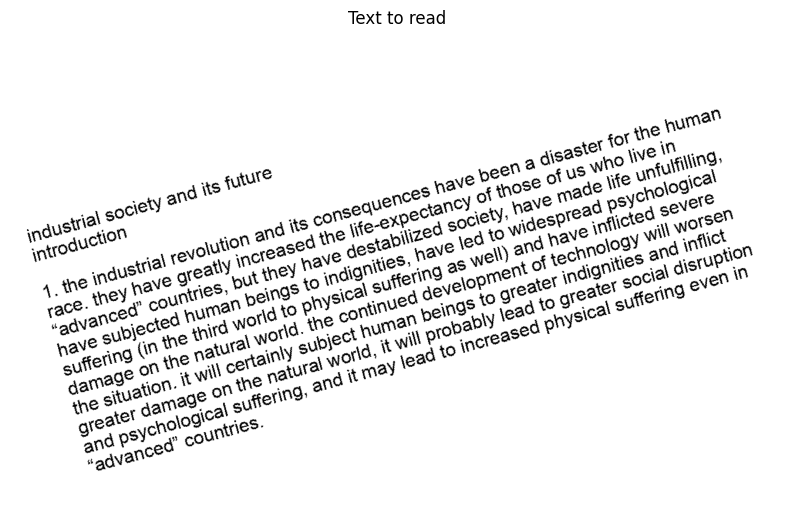

In [1267]:
plot_image(image, "Text to read")

In [1268]:

# Przykład użycia
alphabet = load_alphabet(font_name)
print(f"Alphabet for {font_name} loaded successfully.")

Alphabet for Arial loaded successfully.


In [1269]:
# for sign in alphabet :
#     print(sign)
#     plot_image(alphabet[sign], "")

In [1270]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Oblicz nowy rozmiar obrazu, aby zmieścił się po obrocie
    cos = np.abs(np.cos(angle))
    sin = np.abs(np.sin(angle))
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Przesunięcie do centrum nowego rozmiaru obrazu
    M = cv2.getRotationMatrix2D(center, angle * 180 / np.pi, 1.0)
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # Użyj interpolacji najbliższego sąsiada
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [1271]:
def cut_image(image) :
    image_array = np.array(image)
    # Przyjmijmy, że image_array to zwracana tablica NumPy z funkcji create_text_image()

    # Znajdź indeksy niebiałych pikseli w każdym wymiarze
    non_white_cols = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=1)
    # Znajdź indeksy kolumn zawierające niebiałe piksele
    non_white_rows = np.any(np.any(image_array != [255, 255, 255], axis=-1), axis=0)

    minimal_row = float('inf')
    maximal_row = float('-inf')
    minimal_col = float('inf')
    maximal_col = float('-inf')

    for i in range(len(non_white_rows)) :
        val = non_white_rows[i]
        if val :
            minimal_row = min(minimal_row, i)
            maximal_row = max(maximal_row, i + 1)
    for i in range(len(non_white_cols)) :
        val = non_white_cols[i]
        if val :
            minimal_col = min(minimal_col, i)
            maximal_col = max(maximal_col, i + 1)
    
    x_range = maximal_row - minimal_row
    y_range = maximal_col - minimal_col
    
    new_image_array = np.zeros((y_range, x_range, 3))
    
    for x in range(x_range) :
        for y in range(y_range) :
            new_image_array[y,x] = image_array[minimal_col + y, minimal_row + x]
    
    return new_image_array

-0.27185186298934977


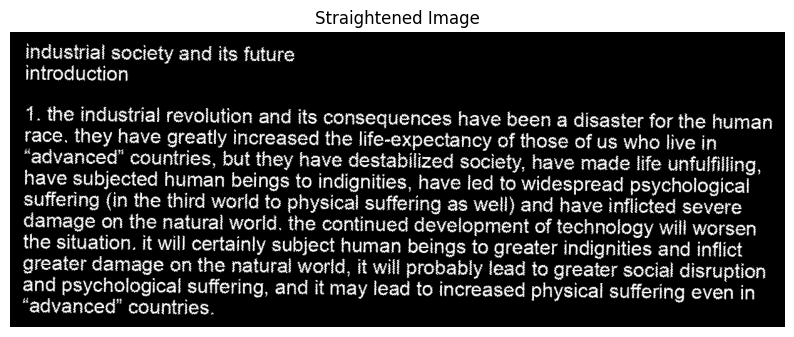

In [1272]:
import cv2
import numpy as np

def add_margins(image, margin):
    h, w = image.shape[:2]
    new_image = np.full((h + 2 * margin, w + 2 * margin, 3), 255, dtype=np.uint8)
    new_image[margin:margin+h, margin:margin+w] = image
    return new_image

def denoise_image(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


def straighten_image(image):
    # Wykrywanie krawędzi za pomocą algorytmu Canny'ego
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    
    # Wykrywanie linii za pomocą transformacji Hougha
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Obliczenie średniego kąta nachylenia linii
    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            angles.append(theta - np.pi / 2)
    
    # Obliczenie średniego kąta nachylenia
    if angles:
        mean_angle = np.mean(angles)
    else:
        mean_angle = 0
    
    print(mean_angle)
    
    # Obrót obrazu o obliczony kąt
    straightened_image = denoise_image(add_margins(cut_image(rotate_image(image, mean_angle)), 20))
    
    image_filename = os.path.join(TEMP_DIR, "image.png")
    cv2.imwrite(image_filename, straightened_image)
    
    return straightened_image

# # Przykład użycia
# image_path = os.path.join(SCRIPT_PATH,"texts",filename)
# image = cv2.imread(image_path)

image = invert_colors(to_grayscale(straighten_image(image)))

# Wyświetlanie wyprostowanego obrazu
plot_image(image, "Straightened Image")


In [1273]:
def calculate_correlation(whole_image, searched_image, normalize=True):
    def rot180(arr):
        return np.rot90(np.rot90(arr))

    image_width, image_height = whole_image.size

    result = ifft2(
        fft2(whole_image) * fft2(rot180(searched_image), s=(image_height, image_width))
    ).real
    if normalize:
        result /= np.abs(np.max(result))
    return result

In [1274]:
def calculate_all_characters_correlations(characters, whole_image, normalize_each=False):
    for character in characters:
        character.correlation = calculate_correlation(
            whole_image=whole_image,
            searched_image=character.image,
            normalize=not normalize_each,
        )
        if normalize_each:
            self_correlation = np.max(
                calculate_correlation(
                    whole_image=character.image,
                    searched_image=character.image,
                    normalize=False,
                )
            )
            character.correlation /= self_correlation

In [1275]:
def mark_found_elements(image_arr, correlation, certainty, selection_size, color):
    found_locations = []
    for y in range(correlation.shape[0]):
        for x in range(correlation.shape[1]):
            if correlation[y, x] > certainty:
                found_locations.append((y, x))

    result = image_arr.copy()
    for y, x in found_locations:
        for dy in range(0, selection_size[0], np.sign(selection_size[0])):
            for dx in range(0, selection_size[1], np.sign(selection_size[1])):
                result[y + dy, x + dx] = color
    return result


def mark_and_display_all_letters(characters, image, certainity=0.95):
    result = from_grayscale(image)
    for character in characters:
        result = mark_found_elements(
            image_arr=result,
            correlation=character.correlation,
            certainty=certainity,
            selection_size=(4, -12),
            color=character.color,
        )
    result = Image.fromarray(result)
    display(result)

In [ ]:
calculate_all_characters_correlations(times_new_roman_characters, whole_image=text)
mark_and_display_all_letters(times_new_roman_characters, certainity=0.96)

In [1276]:
# if os.path.exists(TEMP_DIR) and os.path.isdir(TEMP_DIR) :
#     shutil.rmtree(TEMP_DIR)